<a href="https://colab.research.google.com/github/abhishakvarshney/News-Classification/blob/master/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

Loading all libraries to be used



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, make_scorer
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Data extraction and exploration**

In [2]:
categories = pd.read_csv('categories.csv')
categories.head()

,id,category
0,1,Layoff
1,2,Mergers and Acquisitions
2,3,Mass Hiring
3,4,Executive Movement
4,5,Centre Setup and Expansion


In [3]:
categories.shape

(7, 2)

In [4]:
category_map = pd.read_excel('category_mapping.xlsx')
category_map.head()

,news_id,category_id
0,5cb377684f646938b14a96f1_google,4
1,5cb426d44f646938b10bf6b6_google,4
2,5cb429984f646938b110f937_google,2
3,5cb426b34f646938b10bbeca_google,5
4,5cb426f74f646938b10c3857_google,7


In [5]:
category_map.shape

(3544, 2)

In [6]:
news = pd.read_excel('news_details.xlsx')
news.head()

,news_id,snippet,title,news_description
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...
2,5cb429984f646938b110f937_google,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...
3,5cb426b34f646938b10bbeca_google,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...
4,5cb426f74f646938b10c3857_google,KFH has partnered with IDEMIA to launch Kuwait...,KFH partners with IDEMIA's to launch metal pay...,NaN


In [7]:
news.shape

(3544, 4)

In [8]:
categories.rename(columns={'id':'category_id'}, inplace=True)
categories.head()

,category_id,category
0,1,Layoff
1,2,Mergers and Acquisitions
2,3,Mass Hiring
3,4,Executive Movement
4,5,Centre Setup and Expansion


In [9]:
dataset = pd.merge(news, category_map, on='news_id')
dataset = pd.merge(dataset, categories, on='category_id')
del dataset['category_id']
dataset.shape

(5386, 5)

In [10]:
dataset.head()

,news_id,snippet,title,news_description,category
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN,Executive Movement
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...,Executive Movement
2,5cb427e74f646938b10de598_google,Family values: Andrew Moore wants to devote mo...,Moore steps down from top job at Renault,RENAULT Australia managing director Andrew Moo...,Executive Movement
3,5cb427e74f646938b10de598_google,Family values: Andrew Moore wants to devote mo...,Moore steps down from top job at Renault,RENAULT Australia managing director Andrew Moo...,Executive Movement
4,5cb427e74f646938b10de598_google,Family values: Andrew Moore wants to devote mo...,Moore steps down from top job at Renault,NaN,Executive Movement


In [11]:
dataset['category_id'] = dataset['category'].factorize()[0]

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5386 entries, 0 to 5385
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   news_id           5386 non-null   object
 1   snippet           5375 non-null   object
 2   title             5386 non-null   object
 3   news_description  5102 non-null   object
 4   category          5386 non-null   object
 5   category_id       5386 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 294.5+ KB


In [13]:
dataset.groupby('category').category_id.count()

category
Centre Setup and Expansion     774
Deals                          641
Executive Movement            1875
Layoff                         138
Mass Hiring                     94
Mergers and Acquisitions       641
Partnerships                  1223
Name: category_id, dtype: int64

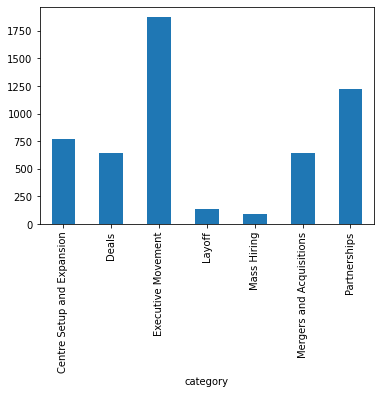

In [14]:
dataset.groupby('category').category_id.count().plot.bar(ylim=0)

In [15]:
category_id_df = dataset[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df

,category,category_id
0,Executive Movement,0
1875,Mergers and Acquisitions,1
2516,Centre Setup and Expansion,2
3290,Partnerships,3
4513,Deals,4
5154,Layoff,5
5292,Mass Hiring,6


In [16]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
id_to_category

{0: 'Executive Movement',
 1: 'Mergers and Acquisitions',
 2: 'Centre Setup and Expansion',
 3: 'Partnerships',
 4: 'Deals',
 5: 'Layoff',
 6: 'Mass Hiring'}

In [17]:
category_to_id

{'Centre Setup and Expansion': 2,
 'Deals': 4,
 'Executive Movement': 0,
 'Layoff': 5,
 'Mass Hiring': 6,
 'Mergers and Acquisitions': 1,
 'Partnerships': 3}

In [18]:
#check nulls..
dataset.isnull().sum()

news_id               0
snippet              11
title                 0
news_description    284
category              0
category_id           0
dtype: int64

In [19]:
(dataset['snippet'].isnull() & dataset['news_description'].isnull()).sum()

0

In [20]:
dataset['snippet'] = dataset['snippet'].fillna(dataset['news_description'])
dataset['news_description'] = dataset['news_description'].fillna(dataset['snippet'])

In [21]:
dataset.isnull().sum()

news_id             0
snippet             0
title               0
news_description    0
category            0
category_id         0
dtype: int64

Using wordcloud we can visualize our data.

<Figure size 432x288 with 0 Axes>

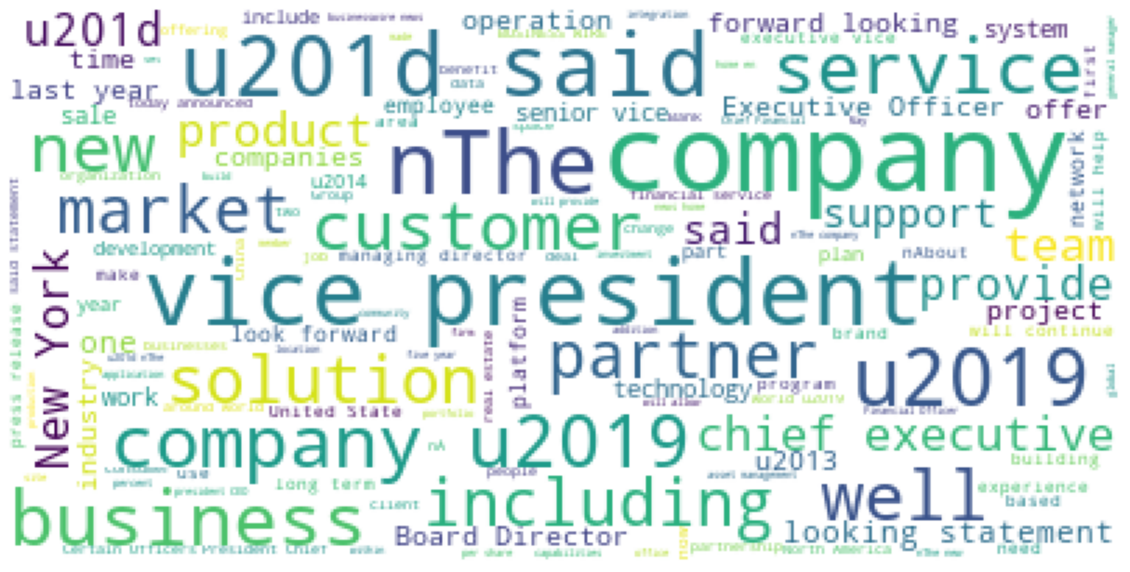

In [22]:
from wordcloud import WordCloud
text = " ".join(dataset['news_description'])
wordcloud = WordCloud().generate(text)
plt.figure()
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(text),
    max_font_size=40,
    relative_scaling=.5).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


## **Data Preprocessing**

### **Vectorization of data**
  Vectorize the data using Bag of words (BOW)

In [23]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

vectorizer.fit(iter(dataset['news_description']))
Xtr = vectorizer.transform(iter(dataset['news_description']))

encoder = LabelEncoder()
encoder.fit(dataset['category'])
Ytr = encoder.transform(dataset['category'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Lets look at what exactly is this vectorizer doing. We will first create reverse dictionary from the vectorizer. Iterating over the vectorized sentence Nasa scientists are good. We get the vector to be representative of three words "good", "nasa" and "scientists". The order has been changed because bag of words does not preserve order.

In [24]:
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word

vector = vectorizer.transform(iter(['Nasa scientists are good']))
indexes = vector.indices
for i in indexes:
    print(reverse_vocabulary[i])

good
nasa
scientists


## **Feature Reduction**
We can check the variance of the feature and drop them based on a threshold

In [25]:
import copy
print("Number of features before reduction : ", Xtr.shape[1])
selection = VarianceThreshold(threshold=0.001)
Xtr_whole = copy.deepcopy(Xtr)
Ytr_whole = copy.deepcopy(Ytr)
selection.fit(Xtr)
Xtr = selection.transform(Xtr)
print("Number of features after reduction : ", Xtr.shape[1])

Number of features before reduction :  46420
Number of features after reduction :  20444


## **Sampling data**
We will count the number of diffrent labels in dataset and plot a pie chart distribution.

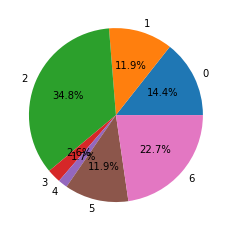

In [26]:
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

As we can see the class labels are not uniformy distributed so we will use SMOT and oversample the classes which are less in number so that classes are equally distributed



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


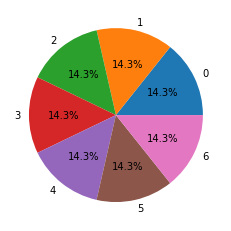

In [27]:
sm = SMOTE(random_state=42)
Xtr, Ytr = sm.fit_sample(Xtr, Ytr)
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

## **Data Analysis**

We will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. This statistic represents words’ importance in each document. We use a word's frequency as a proxy for its importance: if particular word is mentioned 25 times in a document, it might be more important than if it was only mentioned once. We also use the document frequency (the number of documents containing a given word) as a measure of how common the word is. This minimizes the effect of stop-words such as pronouns, or domain-specific language that does not add much information (for example, a word such as "news" that might be present in most documents).

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(dataset.news_description).toarray()
labels = dataset.category_id

we can use the chi-squared test to find the terms are the most correlated with each of the categories

In [29]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'Centre Setup and Expansion':
  . Most correlated unigrams:
       . opening
       . foot
       . square
  . Most correlated bigrams:
       . square feet
       . square foot
       . 000 square
# 'Deals':
  . Most correlated unigrams:
       . agreement
       . awarded
       . contract
  . Most correlated bigrams:
       . year contract
       . flights singapore
       . garuda indonesia
# 'Executive Movement':
  . Most correlated unigrams:
       . served
       . directors
       . board
  . Most correlated bigrams:
       . certain officers
       . new role
       . board directors
# 'Layoff':
  . Most correlated unigrams:
       . layoff
       . cuts
       . layoffs
  . Most correlated bigrams:
       . warn notice
       . cut costs
       . job cuts
# 'Mass Hiring':
  . Most correlated unigrams:
       . posts
       . candidates
       . recruitment
  . Most correlated bigrams:
       . official website
       . bank recruitment
       . recruitment 2019
# 'Mergers a

In [30]:
##dimension reduction 
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

We can also use dimensionality reduction techniques, such t-SNE to project our high dimensional tf-idf features into a 2D plane, where they can be visualized.

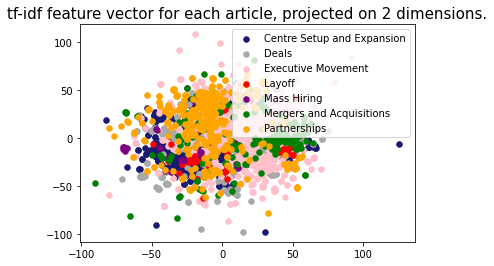

In [31]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey', 'red', 'purple']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

## **Comparing different models**

In [32]:
from sklearn.model_selection import cross_val_score

models = [
    DummyClassifier(strategy="stratified"),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    SVC(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3),
    MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), random_state=1, max_iter=400)
]

In [33]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [34]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  print(model_name)
  accuracies = cross_val_score(model, Xtr, Ytr, cv=CV, scoring=make_scorer(classification_report_with_accuracy_score))
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

DummyClassifier
              precision    recall  f1-score   support

           0       0.13      0.12      0.13       375
           1       0.16      0.15      0.16       375
           2       0.15      0.16      0.16       375
           3       0.19      0.17      0.18       375
           4       0.12      0.12      0.12       375
           5       0.12      0.12      0.12       375
           6       0.13      0.15      0.14       375

    accuracy                           0.14      2625
   macro avg       0.14      0.14      0.14      2625
weighted avg       0.14      0.14      0.14      2625

              precision    recall  f1-score   support

           0       0.15      0.17      0.16       375
           1       0.19      0.20      0.20       375
           2       0.18      0.17      0.17       375
           3       0.18      0.17      0.17       375
           4       0.14      0.14      0.14       375
           5       0.13      0.12      0.13       375
        

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.92      0.94      0.93       375
           1       0.94      0.91      0.92       375
           2       0.95      0.85      0.90       375
           3       0.96      0.98      0.97       375
           4       0.98      0.98      0.98       375
           5       0.95      0.94      0.94       375
           6       0.88      0.95      0.92       375

    accuracy                           0.94      2625
   macro avg       0.94      0.94      0.94      2625
weighted avg       0.94      0.94      0.94      2625



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       375
           1       0.91      0.93      0.92       375
           2       0.94      0.85      0.90       375
           3       0.97      1.00      0.98       375
           4       0.99      0.99      0.99       375
           5       0.94      0.95      0.94       375
           6       0.91      0.90      0.91       375

    accuracy                           0.94      2625
   macro avg       0.94      0.94      0.94      2625
weighted avg       0.94      0.94      0.94      2625



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.92      0.95      0.93       375
           1       0.90      0.96      0.93       375
           2       0.96      0.86      0.91       375
           3       0.91      1.00      0.95       375
           4       1.00      0.98      0.99       375
           5       0.96      0.95      0.96       375
           6       0.97      0.90      0.93       375

    accuracy                           0.94      2625
   macro avg       0.95      0.94      0.94      2625
weighted avg       0.95      0.94      0.94      2625



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       375
           1       0.95      0.96      0.95       375
           2       1.00      0.90      0.94       375
           3       0.89      1.00      0.94       375
           4       0.99      0.99      0.99       375
           5       0.97      0.95      0.96       375
           6       0.94      0.93      0.94       375

    accuracy                           0.96      2625
   macro avg       0.96      0.96      0.96      2625
weighted avg       0.96      0.96      0.96      2625



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.95      0.98      0.96       375
           1       0.97      0.96      0.96       375
           2       1.00      0.88      0.94       375
           3       0.92      1.00      0.96       375
           4       0.99      0.99      0.99       375
           5       0.92      0.98      0.94       375
           6       0.95      0.90      0.93       375

    accuracy                           0.96      2625
   macro avg       0.96      0.96      0.96      2625
weighted avg       0.96      0.96      0.96      2625

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.67      0.89      0.77       375
           1       0.73      0.89      0.80       375
           2       0.92      0.15      0.26       375
           3       0.73      0.97      0.83       375
           4       0.85      0.99      0.92       375
           5       0.88      0.93      0.90       375
   

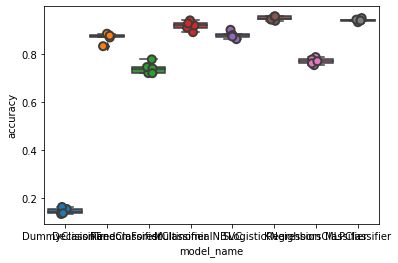

In [35]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [36]:
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.867276
DummyClassifier           0.145829
KNeighborsClassifier      0.768990
LogisticRegression        0.946895
MLPClassifier             0.939962
MultinomialNB             0.916495
RandomForestClassifier    0.739810
SVC                       0.878400
Name: accuracy, dtype: float64

In [37]:
cv_df

,model_name,fold_idx,accuracy
0,DummyClassifier,0,0.142095
1,DummyClassifier,1,0.154286
2,DummyClassifier,2,0.162667
3,DummyClassifier,3,0.133333
4,DummyClassifier,4,0.136762
5,DecisionTreeClassifier,0,0.831619
6,DecisionTreeClassifier,1,0.878095
7,DecisionTreeClassifier,2,0.867810
8,DecisionTreeClassifier,3,0.883429
9,DecisionTreeClassifier,4,0.875429


## **Final Model: Logistic Regression Model**
**Logistic Regression** works the best. Lets run GLM on our test data and get the confusion matrix and its heat map.

In [45]:
model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test = train_test_split(Xtr, Ytr, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
category_id_df = dataset[['category', 'category_id']].drop_duplicates().sort_values('category_id')

Text(0.5, 15.0, 'Predicted')

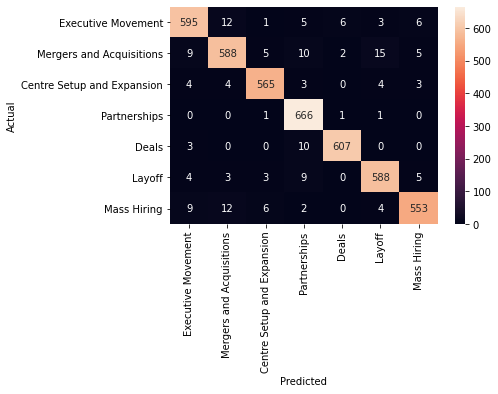

In [47]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Given the very high accuracy of our model, almost all the predictions end up on the diagonal (predicted label = actual label), right where we want them to be!

In [48]:
for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      print('')

'Mergers and Acquisitions' predicted as 'Executive Movement' : 9 examples.

'Centre Setup and Expansion' predicted as 'Executive Movement' : 4 examples.

'Deals' predicted as 'Executive Movement' : 3 examples.

'Layoff' predicted as 'Executive Movement' : 4 examples.

'Mass Hiring' predicted as 'Executive Movement' : 9 examples.

'Executive Movement' predicted as 'Mergers and Acquisitions' : 12 examples.

'Centre Setup and Expansion' predicted as 'Mergers and Acquisitions' : 4 examples.

'Layoff' predicted as 'Mergers and Acquisitions' : 3 examples.

'Mass Hiring' predicted as 'Mergers and Acquisitions' : 12 examples.

'Mergers and Acquisitions' predicted as 'Centre Setup and Expansion' : 5 examples.

'Layoff' predicted as 'Centre Setup and Expansion' : 3 examples.

'Mass Hiring' predicted as 'Centre Setup and Expansion' : 6 examples.

'Executive Movement' predicted as 'Partnerships' : 5 examples.

'Mergers and Acquisitions' predicted as 'Partnerships' : 10 examples.

'Centre Setup and